In [1]:
from scipy.io import loadmat
import os
from datetime import datetime
import numpy as np
from tensorflow.keras.preprocessing import image
from tqdm import tqdm_notebook
import h5py
import time


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calculate_age(taken, dob):
    birth = datetime.fromordinal(max(int(dob) - 366, 1))
    
    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [3]:
def load_data(data_dir, dataset):
    
    meta = loadmat(os.path.join(data_dir, "{}.mat".format(dataset)))
    
    full_path = meta[dataset][0, 0]["full_path"][0]
    
    face_score = meta[dataset][0, 0]["face_score"][0]
    
    second_face_score = meta[dataset][0, 0]["second_face_score"][0]
    
    dob = meta[dataset][0, 0]["dob"][0]
    
    photo_taken = meta[dataset][0, 0]["photo_taken"][0]
    
    name = meta[dataset][0, 0]["name"][0]
    
    ages = np.array([calculate_age(photo_taken[i], dob[i]) for i in range(len(dob))])
    
    indecies_to_delete = []
    
    for i, age in enumerate(ages):
        if age > 100 or age < 0:
            indecies_to_delete.append(i)
        
        if face_score[i] < 1:
            indecies_to_delete.append(i)
            
        if not np.isnan(second_face_score[i]):
            indecies_to_delete.append(i)
            
        
    print("Removing", len(indecies_to_delete), "images")
            
    ages = np.delete(ages, indecies_to_delete)
    full_path = np.delete(full_path, indecies_to_delete)
     
    images = []
    for img_path in tqdm_notebook(full_path):
        images.append(img_path[0])
    
    images = np.array(images)
    
    return images, ages

In [4]:
def load_images(data_dir, image_paths, image_shape):
    
    images = None
    num_images = len(image_paths)
    
    for i, image_path in tqdm_notebook(enumerate(image_paths), total=num_images, leave=False):
    
        try:
            # Load image
            loaded_image = image.load_img(os.path.join(data_dir, image_path), target_size=image_shape)
            
            # Convert PIL image to numpy ndarray
            loaded_image = image.img_to_array(loaded_image)

            # Add another dimension (Add batch dimension)
            loaded_image = np.expand_dims(loaded_image, axis=0)
            
            if images is None:
                images = loaded_image
            else:
                images = np.concatenate([images, loaded_image], axis=0)
        except Exception as e:
            print("Error:", i, e)

    return images

In [5]:
def image_chunk_generator(images, chunksize):
    for i in range(0, images.shape[0], chunksize):
        yield images[i:i + chunksize]

In [ ]:
#images = load_images("data/wiki_crop")
images, ages = load_data("data/wiki_crop", "wiki")

In [ ]:
data_generator = image.ImageDataGenerator(rescale=1. / 255)
image_shape = (64, 64, 3)

num_imgs = images.shape[0]
img_pr_process = num_imgs // 80

chunk_generator = image_chunk_generator(images, img_pr_process)

finnished_images = []
for image_chunk in tqdm_notebook(chunk_generator, total = 81, desc="Image chunks"):
    loaded_images = load_images("data/wiki_crop", image_chunk, (image_shape[0], image_shape[1]))
    finnished_images.append(data_generator.standardize(loaded_images))

loaded_images = np.concatenate(finnished_images)

In [ ]:
with h5py.File("wiki_preprocesed.hdf5", "w") as f:
    f.create_dataset("images", data=loaded_images, compression="gzip", compression_opts=9)
    f.create_dataset("ages", data=ages)

In [ ]:
start = time.time()
with h5py.File('wiki_preprocesed.hdf5', 'r') as f:
    n_ages = np.array(f.get('ages'))
    n_images = np.array(f.get('images'))
    
end = time.time()
print(end - start)

In [ ]:
print(n_ages.shape)
print(n_images.shape)

In [ ]:
plt.imshow(n_images[10])

In [6]:
print("Creating imdb dataset")
data_generator = image.ImageDataGenerator(rescale=1. / 255)
image_shape = (64, 64, 3)

print("Loading data")

images, ages = load_data("data/imdb_crop", "imdb")
num_imgs = images.shape[0]
img_pr_process = num_imgs // 400

chunk_generator = image_chunk_generator(images, img_pr_process)

print("preprocessing images")

finnished_images = []
for image_chunk in tqdm_notebook(chunk_generator, total = img_pr_process+1, desc="Image chunks"):
    loaded_images = load_images("data/imdb_crop", image_chunk, (image_shape[0], image_shape[1]))
    finnished_images.append(data_generator.standardize(loaded_images))

loaded_images = np.concatenate(finnished_images)

print("writing the data")

with h5py.File("imdb_preprocesed.hdf5", "w") as f:
    f.create_dataset("images", data=loaded_images, compression="gzip", compression_opts=9)
    f.create_dataset("ages", data=ages)   

print("done!")

Removing 287434 images



done!


In [ ]:
print(images.shape)
print(ages.shape)

In [7]:
start = time.time()
with h5py.File('imdb_preprocesed.hdf5', 'r') as f:
    n_ages = np.array(f.get('ages'))
    n_images = np.array(f.get('images'))
end = time.time()
print(end - start)

69.06746172904968


In [8]:
print(n_ages.shape)
print(n_images.shape)

(174632,)
(174632, 64, 64, 3)


24


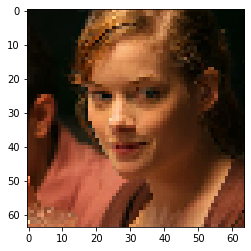

In [17]:
t = 174620
print(n_ages[t])
plt.imshow(n_images[t])